<a href="https://colab.research.google.com/github/danielleitesoares/Work_Sentimental_Analyzer_Of_Restaurant_Issue/blob/main/Analise_dos_Sentimentos_Restaurantes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Analise de Sentimentos Restaurantes**
> Equipe: Leonardo Rocha, Paulo Correa e Daniel Soares
> Turma 02





### 0.Importação das Bibliotecas Utilizadas 




In [1]:
# coding = utf-8  
#Bibliotecas Básicas 
import pandas as pd
import numpy as np
import json
import nltk
import time  # avaliar
import sys
import unicodedata
import requests
#Bibliotecas de Gráficos e Relatórios 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas_profiling as ppf
from pandas_profiling import ProfileReport

#Bibliotecas de Análise de Sentimentos
import textblob


### 1.Tratamento do dataset-v2.dat

##### 1.1. Abrindo o Dataset 

In [2]:
nltk.download('punkt')
! git clone https://github.com/paulordie/sentimental_ds
%cd sentimental_ds/

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Cloning into 'sentimental_ds'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 101 (delta 1), reused 6 (delta 1), pack-reused 95
Receiving objects: 100% (101/101), 79.73 MiB | 19.76 MiB/s, done.
Resolving deltas: 100% (51/51), done.
Checking out files: 100% (12/12), done.
/content/sentimental_ds


##### 1.2 Abrindo e mostrando o Dataset do arquivo .dat


In [3]:
dados = open('dataset-v2.dat')
a = dados.readlines()# Criar uma lista com todos as linhas em strings 
v = [] # vetor para salvar cada linha em json  
#Comando for para correr por cada item de "a" que está as linhas 
for c in a:
  parsed_c = json.loads(c) #Traransformar as strings de "a" em arquivos json
  data = pd.json_normalize(parsed_c) #Normalizando o arquivo json 
  v.append(data)#jogamos os arquivos em 'V'
  #aqui vamos concatenar cada linha que está em 'V' para um unico dataset df 
df = pd.concat(objs=v,axis=0) # Concatenando 

##### 1.3 Salvando em outros formatos

In [5]:
#Converterndo e Salvando em CSV
from google.colab import drive
drive.mount('/content/drive')

df.to_csv('/content/drive/My Drive/dataset123.csv')#salvando o arquivo em csv  \\\\\\\\\\\\\\\\\\\\\verificar
#Convertendo e salvar em excel 
df.to_excel('/content/drive/My Drive/dataset.xlsx')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### 1.4 Exibindo o Head do dataset

In [6]:
df = df.rename(columns={'itemReviewed.name':'Name','itemReviewed.address.streetAddress':'StressAddress','itemReviewed.address.addressLocality':'AddressLocality','itemReviewed.address.addressRegion':'AddressRegion','itemReviewed.address.postalCode':'PostalCode','itemReviewed.address.country':'Country','itemReviewed.website':'Website','itemReviewed.email':'Email','itemReviewed.phoneNumber':'PhoneNumber','itemReviewed.averageRating':'AverageRating'})
df = df.reset_index(drop=True)
df.head(10)


,title,reviewId,restaurantId,author,reviewBody,language,mobileDevice,userLocation,publicationDate,visitDate,ratingValue,Name,StressAddress,AddressLocality,AddressRegion,PostalCode,Country,Website,Email,PhoneNumber,AverageRating
0,Jantar,692856288,2344932,larinhavercosa222,"Comida maravilhosa, lugar do verdadeiro chicle...",pt,True,"São Carlos, SP",26/07/2019,07/2019,5,Imperador dos Camarões,Avenida Doutor Antônio Gouveia,,Alagoas,57030-170,Brasil,http://www.imperadordoscamaroes.com.br,contato@imperadordoscamaroes.com.br,+55 82 3231-4134,4.5
1,Uma boa experiência.,229208487,3720906,Pano P,"Comida boa, drinks legais e um ambiente bem ac...",pt,True,"Manaus, AM",16/09/2014,None,4,Guacamole Natal,Avenida Praia de Ponta Negra 9068 Ponta Negra,,Rio Grande do Norte,59092-100,Brasil,http://www.facebook.com/GuacamoleNatal,guacamolenatal@gmail.com,+55 84 3219-3646,4.5
2,Otimo self service,679002332,2248105,Magma100,"Excelente pra ir com a família! Ótima Comida, ...",pt,True,"Goiânia, GO",04/06/2019,07/2018,4,Chica Pitanga,Rua Petrolina 19,Recife,Pernambuco,51021-250,Brasil,http://www.chicapitanga.com.br,chicapitanga@chicapitanga.com.br,+55 81 3334-8260,4.5
3,O sorvete mais tradicional do estado,355671519,8168302,Yurie M,Tomo sorvete na Visabor faz mais de 30 anos. S...,pt,False,"Aracaju, SE",15/03/2016,01/2016,5,Sorvetes Vi Sabor,Avenida Francisco Porto 59 Grageru,Aracaju,Sergipe,,Brasil,None,None,None,4.0
4,Melhor hamburger!,268741921,5395141,Debora_C85,O melhor hamburger que já comi! Excelente aten...,pt,False,"Rio de Janeiro, RJ",28/04/2015,04/2015,5,Z Deli Sandwich Shop,Rua Haddock Lobo 1386 Jardins,São Paulo,Estado de São Paulo,01414-002,Brasil,http://www.facebook.com/zdelisandwichshop/,None,551130830021,4.5
5,Um achado maravilhoso!,482361860,12209902,Monique C,"O restaurante é novo, super acolhedor e charmo...",pt,False,None,07/05/2017,05/2017,5,Trattoria della Gloria,Rua do Russel 450,Rio de Janeiro,Estado do Rio de Janeiro,22210-010,Brasil,https://www.facebook.com/trattoriadellagloria....,info@trattoriadellagloria.com.br,+55 21 3435-6789,4.5
6,Saboroso,431356071,5565144,ChrisWings,"Fomos num sábado, ambiente elegante, equipe ge...",pt,True,"Brasília, DF",24/10/2016,10/2016,4,Tomyam,"José Maria Lisboa, 1065 Jardim Paulista",São Paulo,Estado de São Paulo,01423-003,Brasil,http://www.tomyam.com.br/,tomyamsp@tomyamsp.com.br,+55 11 4329-1002,4.0
7,Bom trabalho,361607766,2408078,lucianasoares18,Comida ótima e com bom atediamento e com muita...,pt,False,"Vila Velha, ES",04/04/2016,04/2016,4,Ilha do Caranguejo - Vitória,"Rua Alcino Pereira Netto, 570 - Jardim Camburi...",Vitória,Espírito Santo,29090-540,Brasil,http://www.ilhadocaranguejo.com.br,ilha@ilha.es,+55 27 3395-0244,4.5
8,Maravilhoso!,622424870,9738862,Andrezza O,"Ambiente agradável, preço totalmente acessível...",pt,True,"Teresina, PI",05/10/2018,10/2018,5,Vertigo Restaurante,"R. Aviador Irapua Rocha, 2370 Bairro Ininga",Teresina,Piauí,64049-740,Brasil,None,None,08632334338,4.0
9,Mais tradicional de BH,400149803,3514720,Leonardo R,A pizzaria é a mais tradicional de Belo Horizo...,pt,False,"Belo Horizonte, MG",01/08/2016,07/2016,5,Pizzarella,"Av. Olegário Maciel, 2.280 - Lourdes",Belo Horizonte,Minas Gerais,,Brasil,http://www.pizzarellasaobento.com.br/home/defa...,None,(31) 3292-3000,4.0


Varredura do JSON por linha

### 3. *Gráfico* dos Dados do DataFrame

##### 3.1 Avaliações por Países em ordem decrescente 

In [ ]:
# Divide o campo User Location com os valores após a , para uma nova coluna denominadas de Estado e Cidade, https://pt.linkedin.com/pulse/dividindo-colunas-por-delimitador-com-python-fernanda-santos
divisao = df['userLocation'].str.split(',') 
Cidade = divisao.str.get(0) 
Estado = divisao.str.get(1)
df['Cidade'] = Cidade.str.upper()
df['Estado'] = Estado.str.upper()
df.head()

,title,reviewId,restaurantId,author,reviewBody,language,mobileDevice,userLocation,publicationDate,visitDate,ratingValue,Name,StressAddress,AddressLocality,AddressRegion,PostalCode,Country,Website,Email,PhoneNumber,AverageRating,cidade,estado,Cidade,Estado
0,Jantar,692856288,2344932,larinhavercosa222,"Comida maravilhosa, lugar do verdadeiro chicle...",pt,True,"São Carlos, SP",26/07/2019,07/2019,5,Imperador dos Camarões,Avenida Doutor Antônio Gouveia,,Alagoas,57030-170,Brasil,http://www.imperadordoscamaroes.com.br,contato@imperadordoscamaroes.com.br,+55 82 3231-4134,4.5,São Carlos,SP,SÃO CARLOS,SP
1,Uma boa experiência.,229208487,3720906,Pano P,"Comida boa, drinks legais e um ambiente bem ac...",pt,True,"Manaus, AM",16/09/2014,None,4,Guacamole Natal,Avenida Praia de Ponta Negra 9068 Ponta Negra,,Rio Grande do Norte,59092-100,Brasil,http://www.facebook.com/GuacamoleNatal,guacamolenatal@gmail.com,+55 84 3219-3646,4.5,Manaus,AM,MANAUS,AM
2,Otimo self service,679002332,2248105,Magma100,"Excelente pra ir com a família! Ótima Comida, ...",pt,True,"Goiânia, GO",04/06/2019,07/2018,4,Chica Pitanga,Rua Petrolina 19,Recife,Pernambuco,51021-250,Brasil,http://www.chicapitanga.com.br,chicapitanga@chicapitanga.com.br,+55 81 3334-8260,4.5,Goiânia,GO,GOIÂNIA,GO
3,O sorvete mais tradicional do estado,355671519,8168302,Yurie M,Tomo sorvete na Visabor faz mais de 30 anos. S...,pt,False,"Aracaju, SE",15/03/2016,01/2016,5,Sorvetes Vi Sabor,Avenida Francisco Porto 59 Grageru,Aracaju,Sergipe,,Brasil,None,None,None,4.0,Aracaju,SE,ARACAJU,SE
4,Melhor hamburger!,268741921,5395141,Debora_C85,O melhor hamburger que já comi! Excelente aten...,pt,False,"Rio de Janeiro, RJ",28/04/2015,04/2015,5,Z Deli Sandwich Shop,Rua Haddock Lobo 1386 Jardins,São Paulo,Estado de São Paulo,01414-002,Brasil,http://www.facebook.com/zdelisandwichshop/,None,551130830021,4.5,Rio de Janeiro,RJ,RIO DE JANEIRO,RJ


In [ ]:
df_Estado = df['Estado'].value_counts().to_frame()[:20] # https://www.kaggle.com/parulpandey/five-ways-to-use-value-counts https://re-thought.com/pandas-value_counts/https://re-thought.com/pandas-value_counts/
df_Estado.head(10)

,Estado
SP,20673
RJ,9780
MG,6422
DF,5605
RS,5398
BA,4445
PE,4220
CE,3539
PR,3088
GO,2950


In [ ]:
# https://dados.gov.br/dataset/malha-geometrica-dos-municipios-brasileiros
df_coord = pd.read_excel ('C:\Python\dowload\DastasetCoord.xls', sheet_name = 'Municípios e Coord. Sedes 2013')

FileNotFoundError: ignored

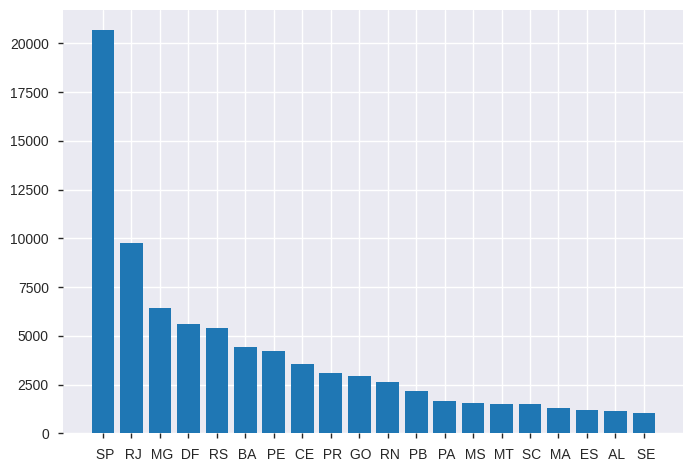

In [ ]:
plt.bar(df_Estado.index,df_Estado['Estado'])
plt.show()

TypeError: ignored

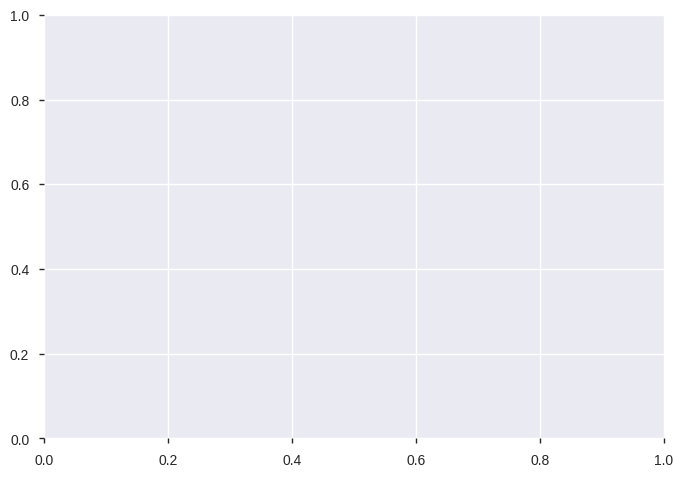

In [ ]:
plt.hist(df['Estado'])

In [7]:
#Gráfico de Estados com mais avalições em ordem descrescente. 
fig = plt.figure(figsize=(30,10)) 
#sns.countplot(y='Estado', order = df_Estado['Estado'].value_counts().index, data=df)
plt.hist(df_Estado.index, bins=80)
plt.title('Estados com mais avaliações',fontsize=40)
plt.xticks(fontsize=10)
#plt.yticks(fontsize=10)
#plt.ylim(0.1,30)
plt.show()

NameError: ignored

<Figure size 2160x720 with 0 Axes>

####3.2 Avalições por Regiões em ordem descrescente. 

####3.3 Avalições por Estados em ordem descrescente.

In [8]:
df_Adressregion = df['AddressRegion'].value_counts().to_frame() # https://www.kaggle.com/parulpandey/five-ways-to-use-value-counts https://re-thought.com/pandas-value_counts/https://re-thought.com/pandas-value_counts/
df_Adressregion.head()

,AddressRegion
Estado de São Paulo,17455
Estado do Rio de Janeiro,10583
Rio Grande do Norte,7075
Ceará,6206
Bahia,6030


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 <a list of 27 Text major ticklabel objects>)

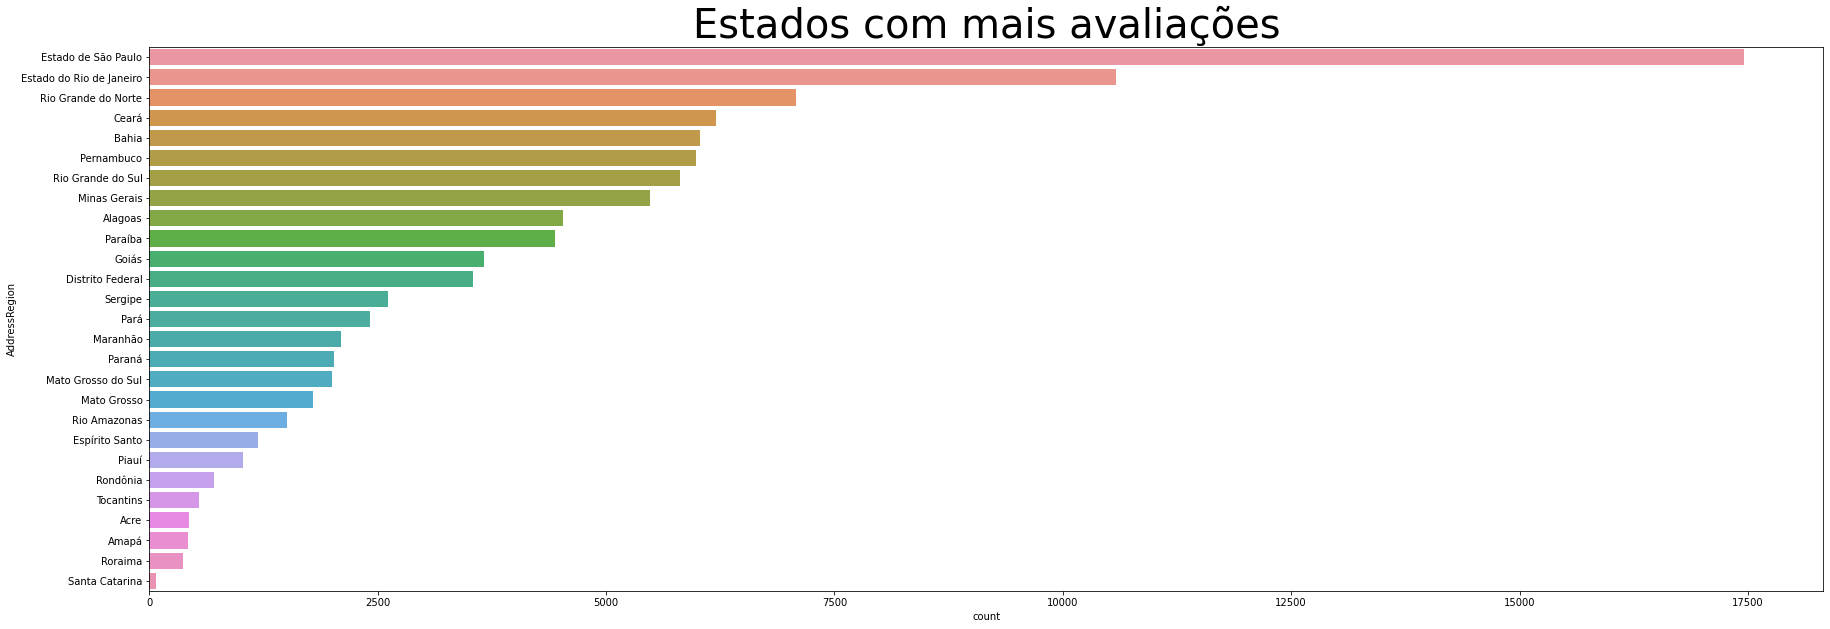

In [9]:
#Gráfico de Estados com mais avalições em ordem descrescente. 
fig = plt.figure(figsize=(30,10)) 
sns.countplot(y='AddressRegion', order = df['AddressRegion'].value_counts().index, data=df)
plt.title('Estados com mais avaliações',fontsize=40)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.ylim(0.1,30)

####3.4 Avalições de Estabelecimentos feitas por Amazonenses 

####3.5 Número de avaliações por tipo de dispositivos 

####3.5 Estabelecimentos de Manaus com comentários em decrescente 

In [ ]:
listOfDataBase = list()
listOfData = []
 
def findKeys(dataBase):
    for register in dataBase:
        try:
            cols = register.split('\n')
            listOfDataBase.append(cols[0])
        except UnicodeDecodeError:
            print("Error on uncode decode findkeys")
    print("Find Keys: ",listOfDataBase)


Iteração das chaves e dos valores

In [ ]:
def passToJson():
    i=0
    for i in range(10): ## tem que colocar a array de todo arquivo
        listOfIssue = listOfDataBase[i]
        i+=1
        time.sleep(1)
        joinList = json.loads(listOfIssue)
        
        for key, value in joinList.items():
            print(key, ":", value)            
            if key == "itemReviewed":
                print("itemReviewed ",joinList["itemReviewed"]["name"])
                print("sub ItemReviewd: ",joinList["itemReviewed"]["address"])
                keyItem = joinList["itemReviewed"]["address"]
                print("valor ", type(keyItem))
                print("StreetAddress: ",keyItem["streetAddress"])
                print("addressLocality: ",keyItem["addressLocality"])
                print("postalCode: ",keyItem["postalCode"])
                print("country: ",keyItem["country"])
                for _keys, _value in keyItem.items():
                    print(_keys,": ",_value)
        
        listOfData.append(joinList)

Exibir do conteúdo por chave e valor

In [ ]:
def showContent(value, collum):
    i=0
    _data = []
    for i in range(value): ##range que vai trazer todas as colunas
        try:
            res = listOfData[i][collum]
            print(type(res))
            print(listOfData[i][collum]) #averageRating, ratingValue etc
            i = i + 1
            print("line: ", i)
        except KeyError:
            print("Key Error")
            continue

valueFindKeys = findKeys(dados) #valor que vai para def passToJson()
dictionaryOfDate = passToJson()
showContent(1,"reviewBody")

Find Keys:  []


IndexError: ignored

In [ ]:
dados

In [ ]:
dados.info()

In [ ]:
diaDaVisita = dados.iloc[:,9:10]
diaDaVisita

In [ ]:
dados.count()

In [ ]:
dados.duplicated()

In [ ]:
avaliacaoGeral = dados.iloc[:,10:11]
avaliacaoGeral.describe()

In [ ]:
dispositivoMovel = dados.iloc[:,6:7]
dispositivoMovel

####3.6 Avaliações por tipo dispositivos

> Bloco com recuo



Text(0.5, 1.0, 'Percentual de avaliação por dispositivos')

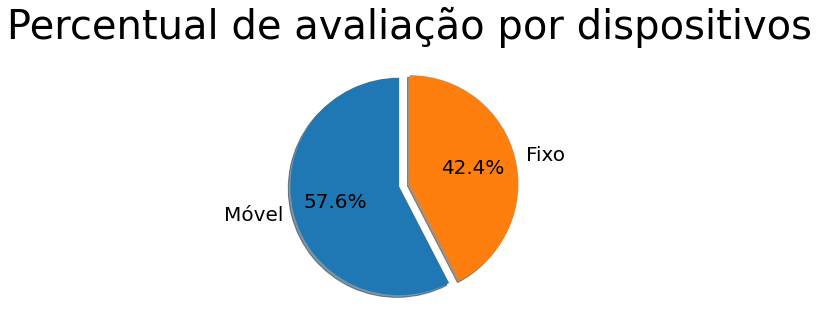

In [73]:
# Percentual de avaliação por dispositivos - https://www.youtube.com/watch?v=wYxDyg1UnMw

plt.rcParams.update({'font.size':20})
rotulos = ['Móvel', 'Fixo']
dfdisp = df.groupby(by='mobileDevice').size()
explode = (0.1,0)
plt.figure(figsize=(5,5))
plt.pie(x=dfdisp, labels=rotulos,explode=explode, autopct='%1.1f%%', startangle=90, shadow=True)
plt.title('Percentual de avaliação por dispositivos',fontsize=40)
##plt.show()

ValueError: ignored

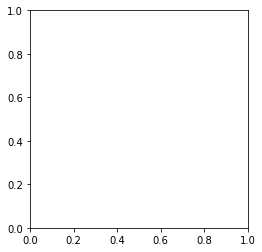

In [57]:
##https://matplotlib.org/3.3.3/gallery/pie_and_polar_charts/pie_features.html#sphx-glr-gallery-pie-and-polar-charts-pie-features-py

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
dfdisp = df.groupby(by='mobileDevice').size()
labels = 'Móvel, Fixo'
sizes = [15, 30, 45, 10]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(dfdisp, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True,startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


###4 Informações sobre o DataFrame

In [ ]:
dados['title']

In [ ]:
profile = ProfileReport(dados, title='Pandas Profile Report', html={'style':{'full_width':True}})

In [ ]:
localDoUsuario = dados.iloc[:,7:8]
localDoUsuario

In [ ]:
dados.describe()

### 2. Análise dos Dados do Dataframe

In [ ]:
import pandas_profiling as ppf 
ppf.ProfileReport(df)

TypeError: ignored

In [ ]:
sns.countplot(dados.groupby('publicationDate').userLocation.count());

In [ ]:
dados.groupby('userLocation').averageRating.count().plot()

In [ ]:
sns.countplot(dados.averageRating);

In [ ]:
sns.countplot(dados.ratingValue);

In [ ]:
sns.catplot(x="mobileDevice", kind="count", palette="ch:.25", data=dados)

### 4. Analise dos Sentimentos 

In [ ]:
def translateByTextBlob():
  dic2 = pd.DataFrame(dados)
  dic2['reviewBody']
  count = 0
  for _x in dic2['reviewBody']:
      count = count + 1  
      print(type(_x))
      x = _x.encode('utf-16', 'surrogatepass').decode('utf-16')
      print(x)
      
      print(count) #vai imprimir todos os reviews= 
          
      comentario_blob = TextBlob(x)
      print(type(comentario_blob))
      comentario_blob_us = comentario_blob.translate(to='us')

      for sentence_br, sentence in zip(comentario_blob.sentences, comentario_blob_us.sentences):
          print(sentence_br, ':', sentence.sentiment.subjectivity)
      if count == 5:
          print('**End**')
          break  

In [ ]:
translateByTextBlob()